In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pycountry
!pip install fuzzywuzzy
!pip install import_ipynb
!pip install movecolumn

In [ ]:
import os
import pickle
import import_ipynb
import glob
import difflib
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
import movecolumn as mc

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from shapely.geometry import Point
from fuzzywuzzy import process, fuzz
from sklearn.linear_model import LinearRegression

In [ ]:
%cd "/content/drive/MyDrive/Shared Projects/Project_Happiness/"

/content/drive/MyDrive/Shared Projects/Project_Happiness


In [ ]:
%run Project_Happiness_Main.ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Shared Projects/Project_Happiness/utils
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.base.Index'>
Stored 'ranked_lr_df' (DataFrame)


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)

In [ ]:
df = ranked_lr_df.iloc[:, :15]

In [ ]:
%store -r constants_geopands ranked_lr_df

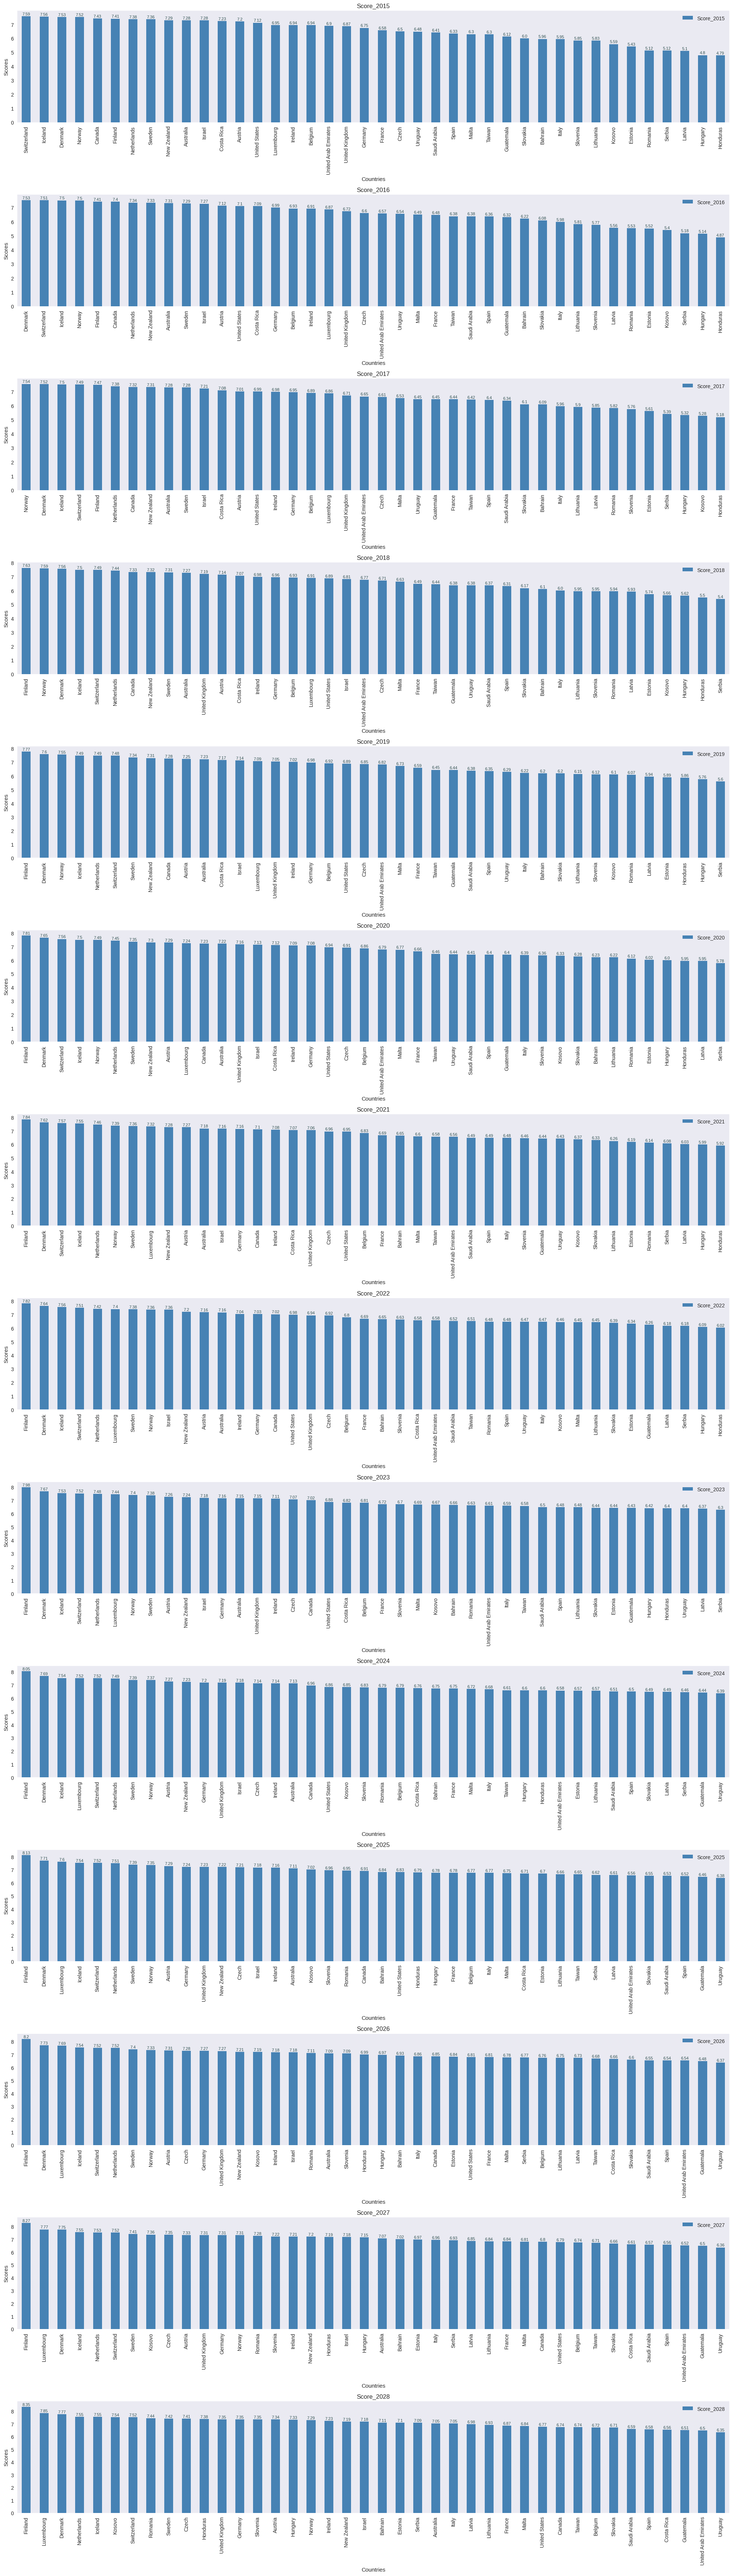

In [ ]:
# Sort the DataFrame by 'Score_2023' and select the top 20 entries
all_scores_sorted = df.sort_values(by='Score_2023', ascending=False).head(40)
columns = df.columns[1:]  # All score columns except 'unique countries'
num_cols = len(columns)

# Adjust the number of rows and columns based on the number of columns to plot
cols = 1  # One column to have each year in a separate row
rows = num_cols  # One row for each year

# Create subplots
fig_1, ax_arr_1 = plt.subplots(rows, cols, squeeze=False, figsize=(20, rows * 5))  # Adjust figsize

# Flatten the ax_arr for easier indexing
ax_arr_2 = ax_arr_1.flatten()

for x, col in enumerate(columns):
    # Ensure the column is numeric and sort by it
    if pd.api.types.is_numeric_dtype(df[col]):
        # Plot the data with countries on the x-axis and scores on the y-axis
        all_scores_sorted.sort_values(by=col, ascending=False).plot(
            kind='bar',  # Vertical bar plot
            y=col,  # Plot the score on the y-axis
            x='unique countries',  # Plot the countries on the x-axis
            ax=ax_arr_2[x],  # Use flat indexing
            title=col,
            color='steelblue'
        )

        # Add data labels to each bar
        for bar in ax_arr_2[x].patches:
            ax_arr_2[x].text(
                bar.get_x() + bar.get_width() / 2,  # Center the label horizontally
                bar.get_height() + 0.03,  # Position label just above the bar
                round(bar.get_height(), 2),  # Round the score to 2 decimal places
                ha='center', va='bottom', fontsize=8, color='darkslategrey'
            )


        for spine in ax_arr_2[x].spines.values():
            spine.set_visible(True)

        # Set axis labels
        ax_arr_2[x].set_ylabel('Scores')
        ax_arr_2[x].set_xlabel('Countries')

# Adjust layout to ensure everything fits well
plt.tight_layout()
plt.show()


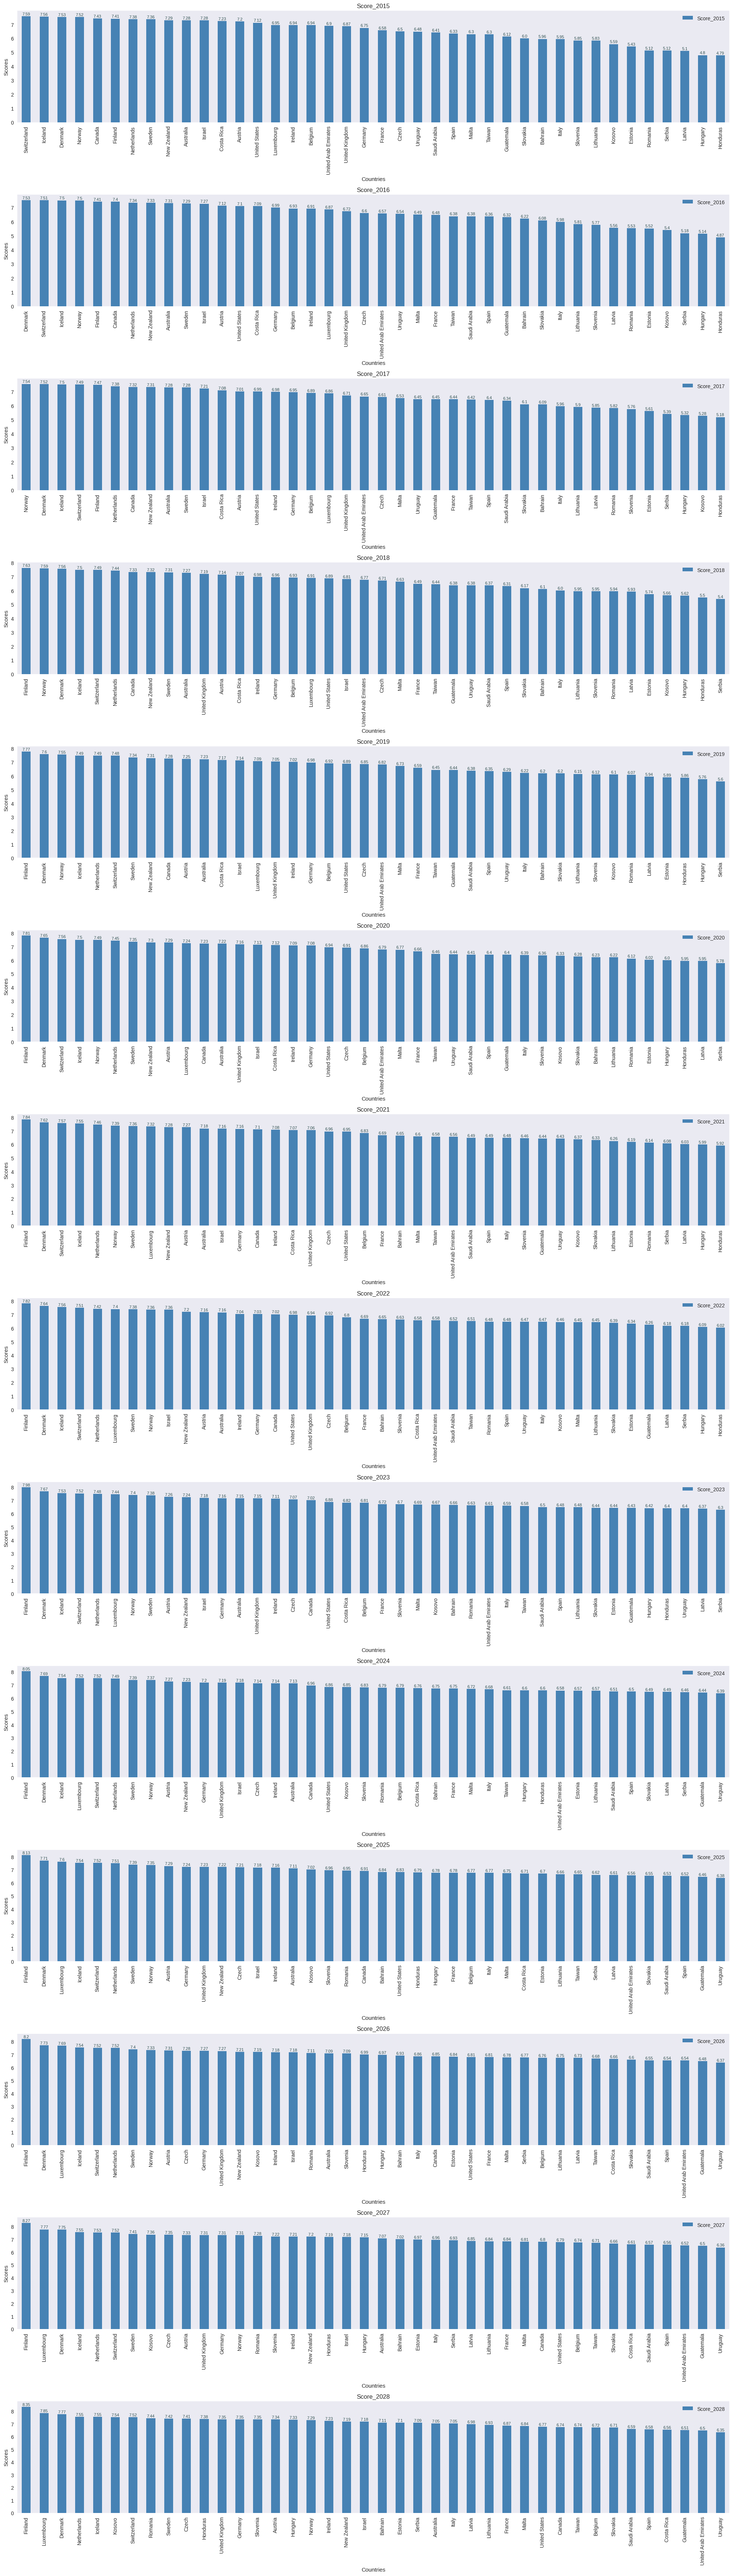

In [ ]:
fig_1

In [ ]:
# Save the figure
with open('fig_1.pkl', 'wb') as f:
    pickle.dump(fig_1, f)

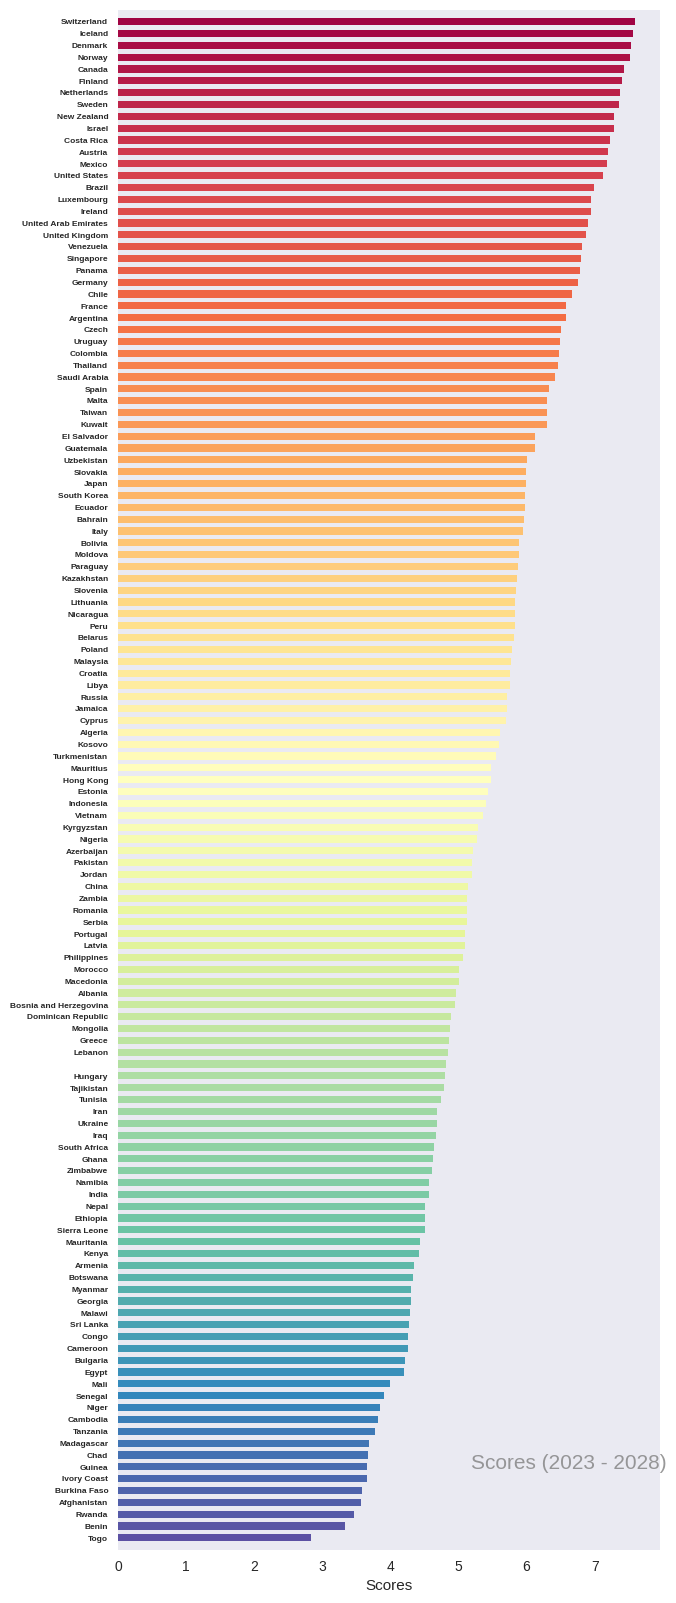

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Define the animate function for updating the plot
def animate(frame_index):
    y_values = [countries_data[country][frame_index] for country in countries_data.keys()]
    sorted_data = sorted(countries_data.items(), key=lambda x: x[1][frame_index])
    tcks = [item[0] for item in sorted_data]
    y_values_sorted = [item[1][frame_index] for item in sorted_data]

    # Clear previous texts
    for text in texts:
        text.remove()
    texts.clear()

    # Add new texts for the current frame
    for i, value in enumerate(y_values_sorted):
        t = axes.text(value + 0.32, i, "{:.2f}".format(value), va='baseline', fontsize=7)
        texts.append(t)

    # Update the bar chart for the current frame
    axes.clear()
    axes.barh(range(len(tcks)), y_values_sorted, color=palette, height=0.6)
    axes.set_yticks(np.arange(0, len(tcks)))
    axes.set_yticklabels(tcks, fontsize=6, weight='bold')
    axes.set_ylim(-1, len(tcks))
    axes.set_xlabel("Scores")

    # Update the title for the current frame
    axes.text(0.65, 0.05, f'Scores (2023 - 2028)', transform=axes.transAxes,
              fontsize=15, color='gray', alpha=0.8,
              ha='left', va='bottom', rotation=360)

# Extract score columns and sample data
score_columns = [col for col in df.columns if str(col).startswith('Score_')]
sampled_scores = df.sample(129)
countries_data = {}

# Match values to unique countries for all years
for country in sampled_scores['unique countries']:
    countries_data[country] = sampled_scores[sampled_scores['unique countries'] == country][score_columns].values.flatten()

# Generate a color palette
palette = list(reversed(sns.color_palette("Spectral", len(countries_data)).as_hex()))

# Initialize the plot
fig = plt.figure(figsize=(7, 20))
axes = fig.add_subplot(1, 1, 1)
plt.style.use("seaborn-v0_8-dark")  # Update to the latest seaborn style

texts = []

# Create the animation
ani = FuncAnimation(fig, animate, interval=1500, frames=range(len(score_columns)), repeat=True)

# # Save the animation as an HTML5 video
video = ani.to_html5_video()

# Display the animation
HTML(video)

In [ ]:
# Save the figure
with open('video.pkl', 'wb') as f:
    pickle.dump(video, f)

In [ ]:
import pycountry

# Function to get ISO Alpha-3 code from country name
def get_iso_alpha_3(country_name):
    try:
        # Lookup the country name in pycountry
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        # Return None if the country is not found
        return None

# Apply the function to create a new column with ISO Alpha-3 codes
df['iso_alpha'] = df['unique countries'].apply(get_iso_alpha_3)

In [ ]:
iso_alpha_mapping = {
    28: "CZE",  # Czech Republic
    59: "RUS",  # Russia
    69: "TUR",  # Turkey
    84: "MKD",  # North Macedonia
    129: "CIV"  # Côte d'Ivoire
}

for index, iso_code in iso_alpha_mapping.items():
    df.loc[index, "iso_alpha"] = iso_code
df_map = df.copy()

In [ ]:
df_map.reset_index(drop=True, inplace=True)

In [ ]:
df_map2 = mc.MoveTo2(df_map,'iso_alpha')

In [ ]:
import plotly.express as px


# Create basic choropleth map
fig_2023 = px.choropleth(df_map2, locations='iso_alpha', color='Score_2023', hover_name='unique countries',
                    projection='natural earth', title='2023 Happiness score by Country')
fig_2024 = px.choropleth(df_map2, locations='iso_alpha', color='Score_2024', hover_name='unique countries',
                    projection='natural earth', title='2024 Happiness score by Country')
fig_2025 = px.choropleth(df_map2, locations='iso_alpha', color='Score_2025', hover_name='unique countries',
                    projection='natural earth', title='2025 Happiness score by Country')
fig_2026 = px.choropleth(df_map2, locations='iso_alpha', color='Score_2026', hover_name='unique countries',
                    projection='natural earth', title='2026 Happiness score by Country')
fig_2027 = px.choropleth(df_map2, locations='iso_alpha', color='Score_2027', hover_name='unique countries',
                    projection='natural earth', title='2027 Happiness score by Country')
fig_2028 = px.choropleth(df_map2, locations='iso_alpha', color='Score_2028', hover_name='unique countries',
                    projection='natural earth', title='2028 Happiness score by Country')
fig_2023.show()
fig_2024.show()
fig_2025.show()
fig_2026.show()
fig_2027.show()
fig_2028.show()

In [ ]:


# Reshape DataFrame to long format for animation
df_long = pd.melt(df_map2, id_vars=['iso_alpha', 'unique countries'],
                  value_vars=[f'Score_{year}' for year in range(2015, 2029)],
                  var_name='Year', value_name='Score')

# Extract year from column names
df_long['Year'] = df_long['Year'].str.extract(r'(\d{4})')

# Create animated choropleth map
interactive_map = px.choropleth(df_long,
                    locations='iso_alpha',
                    color='Score',
                    hover_name='unique countries',
                    animation_frame='Year',
                    range_color=[df_long['Score'].min(), df_long['Score'].max()],
                    projection='natural earth',
                    title='Scores by Country from 2015 to 2028',
                    color_continuous_scale=px.colors.sequential.Plasma)

interactive_map.show()

In [ ]:
# Save the figure
with open('interactive_map.pkl', 'wb') as f:
    pickle.dump(interactive_map, f)